## Topic Modeling with Non-negative Matrix Factorization

#### Import required tools

In [4]:
#!conda install -c conda-forge spacy -y

In [4]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from nltk.chunk import ne_chunk
import spacy


In [5]:
import pandas as pd
import numpy as np
import re
import os
import string
import pickle
from miscScripts import *

import nltk
from nltk.corpus import wordnet 
from nltk import wordpunct_tokenize

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity

from matplotlib import pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [6]:
#Just some text from a Wiki sample to use for testing in lower cells
text = 'A Wizard of Earthsea is a fantasy novel written by American author \
Ursula K. Le Guin and first published by the small press Parnassus in 1968. \
It is regarded as a classic of children\'s literature, and of fantasy, within \
which it was widely influential. The story is set in the fictional archipelago \
of Earthsea and centers around a young mage named Ged, born in a village on the \
island of Gont. He displays great power while still a boy and joins the school\
of wizardry, where his prickly nature drives him into conflict with one of his \
fellows. During a magical duel, Ged\'s spell goes awry and releases a shadow \
creature that attacks him. The novel follows his journey as he seeks to be free \
of the creature. The book has often been described as a Bildungsroman, \
or coming-of-age story, as it explores Ged\'s process of learning to cope with \
power and come to terms with death. The novel also carries Taoist themes about a \
fundamental balance in the universe of Earthsea, which wizards are supposed to maintain, \
closely tied to the idea that language and names have power to affect the material world \
and alter this balance. The structure of the story is similar to that of a traditional epic, \
although critics have also described it as subverting this genre in many ways, such as by \
making the protagonist dark-skinned in contrast to more typical white-skinned heroes. \
A Wizard of Earthsea received highly positive reviews, initially as a work for children\
and later among a general audience as well. It won the Boston Globe–Horn Book Award in\
1969 and was one of the final recipients of the Lewis Carroll Shelf Award in 1979. \
Margaret Atwood called it one of the "wellsprings" of fantasy literature. Le Guin \
wrote five subsequent books that are collectively referred to as the Earthsea Cycle, \
together with A Wizard of Earthsea: The Tombs of Atuan (1971), The Farthest Shore (1972),\
Tehanu (1990), The Other Wind (2001), and Tales from Earthsea (2001). George Slusser \
described the series as a "work of high style and imagination", while Amanda Craig\
sid that A Wizard of Earthsea was"the most thrilling, wise, and beautiful children novel ever".'

In [8]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mariascott/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Importing Pickled Dataframe

In [8]:
# Unpickle the clean data
with open('../data/fclean_novel_non_series.pkl','rb') as fin:
    df = pickle.load(fin)

In [9]:
test = df.iloc[0]['summary']
test

'A Wizard of Earthsea is a fantasy novel written by American author Ursula K. Le Guin and first published by the small press Parnassus in 1968. It is regarded as a classic of children\'s literature, and of fantasy, within which it was widely influential. The story is set in the fictional archipelago of Earthsea and centers around a young mage named Ged, born in a village on the island of Gont. He displays great power while still a boy and joins the school of wizardry, where his prickly nature drives him into conflict with one of his fellows. During a magical duel, Ged\'s spell goes awry and releases a shadow creature that attacks him. The novel follows his journey as he seeks to be free of the creature. The book has often been described as a Bildungsroman, or coming-of-age story, as it explores Ged\'s process of learning to cope with power and come to terms with death. The novel also carries Taoist themes about a fundamental balance in the universe of Earthsea, which wizards are suppos

In [10]:
df.head(1)

,title,summary
0,A Wizard of Earthsea,A Wizard of Earthsea is a fantasy novel writte...


---

## Feature Reduction with NLTK, spaCY, custom stop words

In [11]:
# Turning texts into a list
#Note that the use of the term tokens is a bit of a misnomer
sentences_tokens = df['summary'].tolist()

#### NLTK 

- English stop word library

In [12]:
from nltk.corpus import stopwords 

In [13]:
stop_words = set(stopwords.words('english'))
custom_stop_words = set(['book', 'books', 'author','novel','movie','film','award',
                         'awards','films','movies','authors','publish','published',
                         'written','series', 'television','paperback','illustrated',
                         'story', 'stories','writer','trilogy','fiction','fantasy',
                         'brian','jacques','edgar','rice','burroughs','tom','howard',
                         'diana','jones','wynne','terry','prachett','title','chapter',
                         'character','chronologically', 
                         'first', 'american', 'edition', 'released', 'second', 'world',
                         'children', 'best', 'third', 'also', 'new', 'novels', 'set', 
                         'british', 'adult', 'two',
                         'featuring', 'robert', 'hero', 'first', 'hero',
                         'science', 'time', 'young', 'sequel', 'part', 'four', 'united',
                         'three', 'one', 'may', 'year','magazine', 'later', 'form',
                         'hardcover', 'english', 'last', 'sequels', 'trilogy','wrote','version','novella',
                         'australian','setting','issued','publisher','fictional','release','imprint','style',
                         'published','narrate','narrated','based','setting','expansion','anthology',
                         'copywright','serialized','serial','issued','tagline','taglines',
                         'serially','publication','language','languages','adaption','collaboration',
                         'successors','nominated','novellas','installment','writing','protagonist','titled',
                         'created','including','included','include','chapter','subtitle','illustrations',
                         'nominee','appeared','intended','republished','novellette','themed','prequel',
                         'involving','continues','continued','conclusion','received','originally','directed',
                         'volumes','audiobook','copies','novelization','debut','chapters','trilogies','within',
                         'elements','novelist','reissued','print','expanded','remained','remains','remain',
                         'artist',
                         'artyists','feature','features','ongoing','chronology','known','proceed','proceeded',
                         'proceeds','evans','watt','genre','genres','since','finalist','whose','tell','tells',
                         'cover','covers','preceded','inaugerated','penultimate','resectively','winning',
                         'however',
                         'shorlisted','whose','debuted','introduction','preceding','contain','contains',
                         'finished',
                         'retitled','background','composed','announced','authored','continuing','consists',
                         'details','initially','mainly','simply','critics','would','subsequently',
                         'posthumously',
                         'immediately','previously','longlisted','republication','supposedly','shorlisted',
                         'involves','winning','unabridged','inspired','selling','finally','extended','placed',
                         'trend','referenced','unabridged','abridged','market','accessory','running','takes',
                         'completed','success','million','commercial','sold','comprises', 'becomes','indicates',
                         'took','selected','novelette','shortlisted','name','revolves','usually','combined',
                         'spin',
                         'animated','along','issue','includes','respectively','simultaneously','partularly',
                         'awarded',
                         'made','takes','taken','began','main','concludes','eventually','selected','appear',
                         'appears','states','german','translated','japanese',
                         'russian', 'considered', 'entry', 'together',
                         'transported', 'parts', 'sons', 'swedish', 'interior',
                         'authorized', 'chicago', 'loose', 'core'                         
                        ])
custom_stop_words = stop_words.union(custom_stop_words)

#### spaCy for feature reduction

In [14]:
#Use spaCy for Named Entity Recognition to further refine stopwords
nlp = spacy.load("en_core_web_sm")
ner_stopwords = []
'''
Using Spacy to detect NERs, if it is a person, ordinal, org, date, work of art. Add those to stop words.
Then split the NER with multiple words into single words to be added to the stopwords
'''
def NER_stopwords(summary):
    doc = nlp(summary)
    for ent in doc.ents:
        if ent.label_ in ['PERSON', 'ORDINAL', 'ORG', 'DATE', 'WORK_OF_ART']: 
            word_list = ent.text.lower().split(' ')
            for word in word_list:
                ner_stopwords.append(word)

In [15]:
'''
SpaCy allows us to do name recognition but the way it works, 
the text needs to have it's punctation and Captitalization still.  
Attempt to identify the named entities in the text. Specifically, 
Author Name to remove them from the text.

'''
df['summary'].apply(NER_stopwords)
ner_stopwords = set(ner_stopwords)

In [16]:
custom_stop_words = ner_stopwords.union(custom_stop_words)

## Vectorizing and Creating Document-To-Term Matrix 

Using **TF-IDF** vectorizer  
-test ngram_range  
-min_df:  recall that c used for removing terms that appear too **infrequently**  
-max_df: is used for removing data values that appear too **frequently**  

In [17]:
#TFIDF
#create an instance of the TFID class

vectorizer = TfidfVectorizer(token_pattern = r'\b[a-zA-Z]{3,}\b',
                             stop_words= custom_stop_words, 
                             strip_accents = 'unicode',
                             lowercase=True,
                             ngram_range=(1,3),
                             min_df = 2,
                             max_df = 1.0,
                            )

# Fit transform the documents
#recall that sentences_tokens is df['summary'].tolist()
vectorizer.fit(sentences_tokens)
tf_vector = vectorizer.transform(sentences_tokens)
doc_word = tf_vector
tf_feature_names = vectorizer.get_feature_names()


/opt/miniconda3/envs/metis/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abbas', 'academ', 'admiral', 'ahrairah', 'aleph', 'amanzei', 'amlaib', 'amour', 'anasurimbor', 'ange', 'anglo', 'angus', 'ankh', 'ansichten', 'anti', 'archer', 'arellano', 'argo', 'ariosto', 'aspect', 'auld', 'babies', 'bahram', 'baptiste', 'bas', 'bass', 'bathory', 'bearer', 'beckett', 'bergli', 'bits', 'bjorn', 'blatter', 'boat', 'bobbs', 'bodenburg', 'brien', 'broceliande', 'broderna', 'bronte', 'bros', 'brosel', 'bulgakov', 'bulwer', 'burne', 'burrough', 'cage', 'california', 'cathedral', 'cesar', 'chandagnac', 'changjo', 'charon', 'cher', 'chilperic', 'chosen', 'ciron', 'clock', 'collier', 'colored', 'colt', 'com', 'commander', 'constable', 'cornwell', 'corona', 'critic', 'cuailnge', 'cuaran', 'cuckoo', 'cursor', 'dalucan', 'dane', 'darius', 'dart', 'defense', 'deharme',

In [18]:
#Marie, don't get confused, this code looks redundant, but is getting to the feature names!!!

#Count vectorize and get TF and TF_IDF vectors
#Again, recall that sentences_tokens = df['summary'].tolist()


tf_vector=vectorizer.fit_transform(sentences_tokens)
tf_feature_names = vectorizer.get_feature_names()

In [19]:
# Create Doc-Term-Matrix
#The titles will now be the index and the words w/b the columns
dtm = pd.DataFrame(tf_vector.toarray(),
             index= df.title,
            columns = vectorizer.get_feature_names())#get_feature_names method of object
dtm.head()

,abandon,abducted,abilities,abilities help,ability,ability create,ability see,able,able destroy,aboard,...,xylar gathered sfbc,yarn,youngest,youthful,yvgenie,zamonia,zealand,zimiamvia,zimiamvian,zululand
title,,,,,,,,,,,,,,,,,,,,,
A Wizard of Earthsea,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
Carmilla,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
Don Quixote,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
Erewhon,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.223854,0.0,0.0,0.0
Farmer Giles of Ham,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


In [20]:
dtm.shape

(2290, 4442)

In [21]:
# Save vectorizer and documents as pickle files for visualization (another notebook)
with open('../data/doc_words_novel.pkl','wb') as fout:
    pickle.dump(doc_word, fout)


with open('../data/vectorizer_novel.pkl', 'wb') as fout:
    pickle.dump(vectorizer, fout)

## Topic Modeling  
Now that have Document-to-Term matrix need to get to Topics

### TOPIC MODELING using Non-negative Matrix Factorization (NMF)  

NMF is matrix decomposition that produces 2 matrices with non-negative values.  
It can never undo the application of a latent feature because it cannot use negative values to subtract away the effect.



In [22]:
# Declare a variable to hold a number for topics
n = 10

In [23]:
# Instantiate an instance of the NMF class and pass in n 

nmf = NMF(n)

#Fit the instance of the class to the 
nmf.fit(doc_word)
nmf_doc_topic = nmf.transform(doc_word) # returns array

In [24]:
# Build an NMF with n topics
#recall that tf_vector = vectorizer.transform(sentences_tokens) & doc_word = tf_vector
nmf = NMF(n)
nmf.fit(tf_vector)
nmf_doc_topic = nmf.transform(tf_vector) # returns array

In [25]:
def display_topics(model, feature_names, no_top_words):
    
    '''Function to display n topics and top n words'''
    
    topic_list = []
    for topic_idx, topic in enumerate(model.components_):
        #print(len(topic))
        #print(len(feature_names))
        topic_list.append(' '.join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))
        
        print('Topic %d:' % (topic_idx))
        print(topic_list[topic_idx])
    return topic_list

In [26]:
nmf_doc_topic.shape

(2290, 10)

Recall that the vectorizer function has a get_feature_names method with syntax-> vectorizer.get_feature_names()
Declare a variable, topic_list, to store the topics
Call the display topics function and pass in the required parameters  

        **the model** which in this case is named nmf. 
        **the feature_names** in this case vectorizer is the name assigned to the TfidfVectorizer OBJECT\
        **at the same time calling the .get_feature_names() method**  
        **no_top_words** to specify how many words per topic to be returned

In [27]:
topic_list = display_topics(nmf, vectorizer.get_feature_names(), no_top_words = 10)

Topic 0:
role playing playing role dragonlance dragonlance role playing dragonlance role hexad hexalogy torn fled
Topic 1:
alternate powerful initial blends temeraire medieval standalone mieville fictionalized satire
Topic 2:
find human issues must journey save described use though full
Topic 3:
regular gathered regular gathered seminal grim regular essay essay career regular essay career essay gathered gathered
Topic 4:
adapted doctor true practical stage belongs starring adapted adapted spawned combines
Topic 5:
inaugurated established shared integral linked dying nonfiction self items purposes
Topic 6:
important printed important printed principal father favorite renowned brief rules rather ritual
Topic 7:
japan adaptation anime anime adaptation manga lit manga adaptation produced episode adaptation produced
Topic 8:
historical retelling arthurian explores norwegian seer travelling prime audible historical arthurian
Topic 9:
wonders fabulous fabulous wonders temple murder comprising

### TOPIC MODELING using Latent Dirichlet Allocation (LDA)  
LDA is  a Baysian, i.e. probabalistic, approach for generating the document topic matrix.  Documents are represented as random mixtures over latent topics, and each topic is characterized by a distribution over words.  Dirichet priors are used for the document - topic and term - topic distribitutions.

In [28]:
from sklearn.decomposition import LatentDirichletAllocation

In [29]:
n = 10
lda = LatentDirichletAllocation(n, random_state=42, learning_method='batch')


lda.fit(tf_vector)
lda_doc_topic = lda.transform(tf_vector) # returns array

topic_list = display_topics(lda, vectorizer.get_feature_names(), no_top_words = 20)

Topic 0:
regular important issues seminal protector ashes nothing much thus adapted cavalier mindelan perhaps humorous themes imaginary featured due person full
Topic 1:
adaptation anime due anime adaptation positive theme fight flintlock manga different sextet immortality human academ republic shadowlands fully dedicated find rights
Topic 2:
alternate adapted retelling norwegian combines video travels historical important started principal true juvenile paradox spanish songs darkwar live countries critic
Topic 3:
japan journey initiated escape find hardback germany druid deals meets given threshold take change use medieval finds put boat format
Topic 4:
introduces translation travel find historical right arthurian waking ankh morpork ankh morpork appearing addition help dilemma marked follow sign separate numerous
Topic 5:
role playing playing role italian doctor dragonriders dragonlance save general britain brother dragonriders initiated initiated teenagers description journey africa

In [30]:
topic_names = ['Urban Fantasy',
               'Quest',
               'Role Playing',
               'Epic Fantasy',
               'Anime',
               'Magical Realism',
               'Adapted',
               'Arthurian',
               'Druid',
               'Historical'
              ]

### Take Away:  LDA topics make more sense than NMF topics, initially and throughout numerous updates to stopwords. 

In [52]:
# pd.DataFrame(max_positions)[0].value_counts()

### Clustering and Visualizations

#### KMEANs
Starting with KMeans clustering for completeness, but with high dimensionality think a more sophisticated clustering algorithm is needed.

In [53]:
from sklearn.cluster import KMeans
import numpy as np
kmeans = KMeans(n_clusters=10, random_state=0).fit(lda_doc_topic)
set(kmeans.labels_)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

In [ ]:
kmeans.labels

In [54]:
pd.DataFrame(kmeans.labels_)[0].value_counts()

0    621
1    238
3    210
4    192
5    191
2    189
6    168
9    167
7    161
8    153
Name: 0, dtype: int64

#### T-distributed Stochastic Neighbor Embedding (t-SNE) is a machine learning algorithm for visualization 
It is a nonlinear dimensionality reduction technique well-suited for embedding high-dimensional data for visualization in a low-dimensional space of two or three dimensions.  

Stage 1:t-SNE constructs a probability distribution over pairs of high-dimensional objects in such a way that similar objects have a high probability of being picked while dissimilar points have an extremely small probability of being picked.  Based on Euclidian distance by default, but can be changed.
Stage 2: t-SNE defines a similar probability distribution over the points in the low-dimensional map, and it minimizes the Kullback–Leibler divergence (KL divergence) between the two distributions with respect to the locations of the points in the map.

https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding

 t-SNE stands for t-Distributed Stochastic Neighbor Embedding. It visualizes high-dimensional data by giving each datapoint a location in a two or three-dimensional map. It is a variation of Stochastic Neighbor Embedding (Hinton and Roweis, 2002) that allows optimization, and produces significantly better visualizations by reducing the tendency to lump points together in the center of the map that often renders the visualization ineffective and unreadable. t-SNE is good at creating a map that reveals structure and embedding relationships at many different scales. This is particularly important for high-dimensional inter-related data that lie on several different low-dimensional manifolds, such as images of objects from multiple classes seen from multiple viewpoints.   
 
 http://learningaboutdata.blogspot.com/2014/06/plotting-word-embedding-using-tsne-with.html
 
 https://distill.pub/2016/misread-tsne/ this article indicates that it is important that the perplexity s/b smaller than the number of points to work properly


In [31]:
#Note: using default perplexity of 30 which is related to # of nearest neighbors
#default iterations 1,000
#metric param is the distance used and the default is Euclidian
import numpy as np
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, n_iter = 20000, perplexity = 50).fit_transform(lda_doc_topic)#complexity is default
X_embedded.shape

(2290, 2)

In [32]:
maximums = lda_doc_topic.max(axis=1)
max_positions = []

for i, val in enumerate(lda_doc_topic):
    max_to_match = maximums[i]
    for j, val2 in enumerate(val):
        if val2==max_to_match:
            max_positions.append(j)
            break
            
text_topics = []
for i in max_positions:
    text_topics.append(topic_names[i])

In [43]:
topic_names

['Urban Fantasy',
 'Quest',
 'Role Playing',
 'Epic Fantasy',
 'Anime',
 'Magical Realism',
 'Adapted',
 'Arthurian',
 'Druid',
 'Historical']

In [47]:
#Mapping max positions to title


label_df = pd.DataFrame.from_dict({'title':df['title'], 'positions': max_positions})

label_df.columns = ['title', 'labels']

label_df['genre'] = label_df['labels'].apply(lambda label:topic_names[label])

by_genre_df = label_df.groupby(['genre', 'title']).first()

In [51]:
by_genre_df.loc['Magical Realism']

,labels
title,
A Barnstormer in Oz,5
A Hat Full of Sky,5
A Lion Among Men,5
A Man Has Dreams,5
A Midsummer Tempest,5
...,...
Wintersmith,5
Wizard at Large,5
Wizard of the Pigeons,5


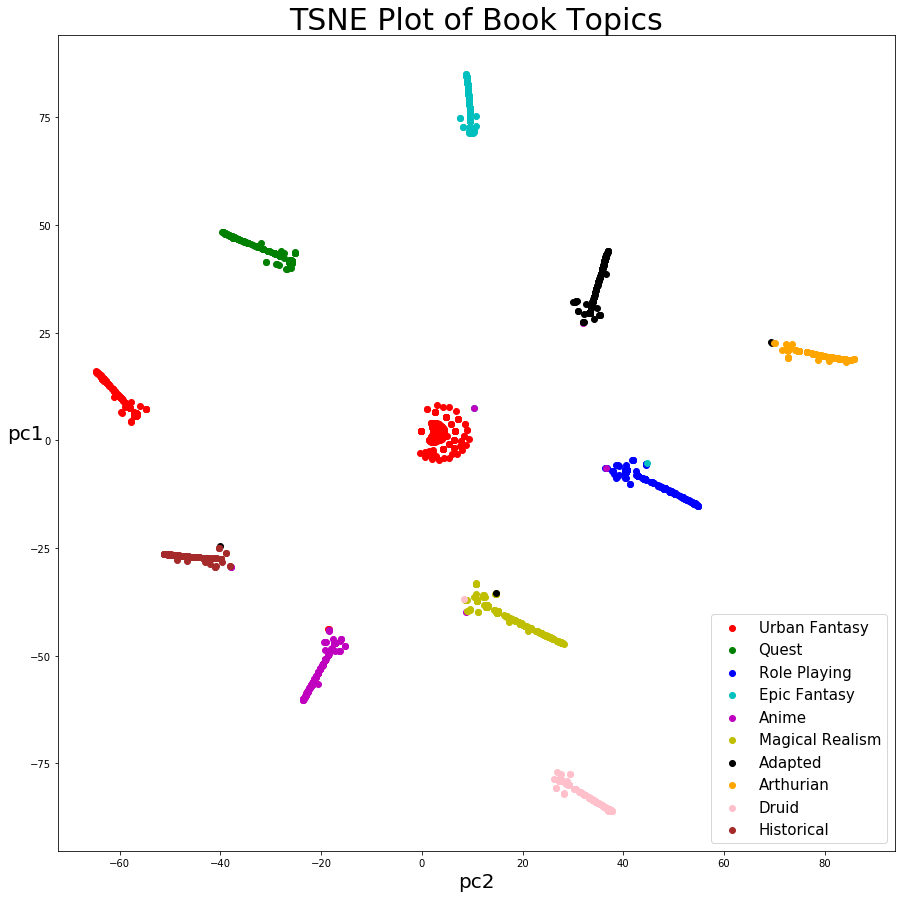

In [111]:
# Topic clusters (max topic loading)
plt.subplots(figsize=(15,15))
# plt.scatter(X_embedded[:,0], X_embedded[:,1],
#             c=max_positions,
#             #c=np.array(max_positions)/max(max_positions),
#             alpha=0.2, cmap=plt.cm.hsv, label=text_topics)

target_ids = range(len(topic_names))
colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'orange', 'pink', 'brown'
for i, c, label in zip(target_ids, colors, topic_names):
    plt.scatter(X_embedded[np.array(max_positions)==i,0],
                X_embedded[np.array(max_positions)==i,1],
                c=c, label=label)

plt.title('TSNE Plot of Book Topics', fontsize = 30)
plt.xlabel('pc2', fontsize = 20)
plt.ylabel('pc1', rotation = 0, fontsize = 20)
plt.legend(loc='lower right', fontsize = 15)
plt.show()

In [60]:
best_topic_df = pd.DataFrame(max_positions, index=df['title'])
best_topic_df.columns = ['best_topic']
best_topic_df
#max_positions

,best_topic
title,
A Wizard of Earthsea,5
Carmilla,0
Don Quixote,5
Erewhon,1
Farmer Giles of Ham,7
...,...
The Barbarian of World's End,5
The Pirate of World's End,5
Wrath of Empire,1


In [61]:
kmeans_df = pd.DataFrame(kmeans.labels_, index=df['title'])
kmeans_df.columns = ['cluster_label']
kmeans_df

,cluster_label
title,
A Wizard of Earthsea,1
Carmilla,9
Don Quixote,1
Erewhon,4
Farmer Giles of Ham,6
...,...
The Barbarian of World's End,1
The Pirate of World's End,1
Wrath of Empire,4


In [62]:
# Save the model as a pickled file for visualization later (another notebook) 
with open(f'../data/lda_novel_{n}_topics_non_series.pkl','wb') as fout:
    pickle.dump(lda, fout)
with open(f'../data/doc_lda_novel_{n}_topics_non_series.pkl','wb') as fout:
    pickle.dump(lda_doc_topic, fout)

In [63]:
# Save the model as a pickled file for visualization later (another notebook) 
with open(f'../data/nmf_novel_{n}_topics_non_series.pkl','wb') as fout:
    pickle.dump(nmf, fout)
with open(f'../data/doc_nmf_novel_{n}_topics_non_series.pkl','wb') as fout:
    pickle.dump(nmf_doc_topic, fout)

### Determining the Appropriate Number of Clusters

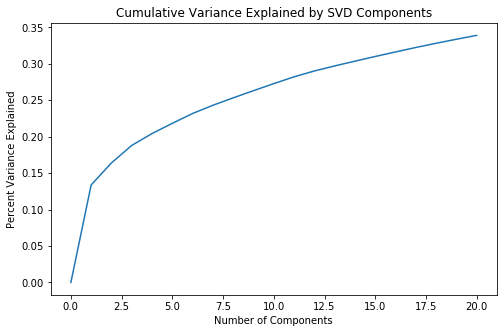

In [68]:
# SVD to justify number of topics

from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfTransformer

# Count vectorize and get TF and TF_IDF vectors
cv=CountVectorizer(max_df=0.80)
tf_vector=cv.fit_transform(sentences_tokens)
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
tf_idf_vector = tfidf_transformer.fit_transform(tf_vector)

svd = TruncatedSVD(n_components=20, n_iter=10, random_state=25)
svd.fit(tf_vector)
plt.subplots(figsize=(8,5))
plt.plot(np.append(np.array([0]), np.cumsum(svd.explained_variance_ratio_)))
plt.title('Cumulative Variance Explained by SVD Components')
plt.xlabel('Number of Components')
plt.ylabel('Percent Variance Explained')
plt.show()

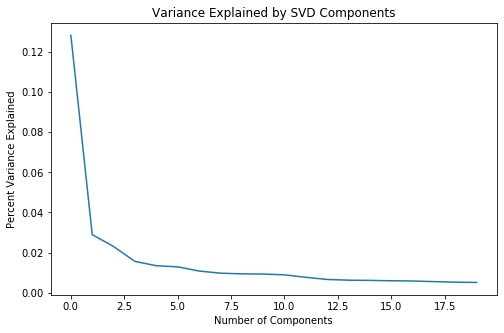

In [69]:
plt.subplots(figsize=(8,5))
plt.plot(svd.explained_variance_/100)
plt.title('Variance Explained by SVD Components')
plt.xlabel('Number of Components')
plt.ylabel('Percent Variance Explained')
plt.show()

### Before working on the Recommendation Engine, I want a brief refresh on bias and variance tradeoff.

https://medium.com/30-days-of-machine-learning/day-3-k-nearest-neighbors-and-bias-variance-tradeoff-75f84d515bdb

[B]ias is an error from erroneous assumptions in the learning algorithm. High bias can cause an algorithm to miss the relevant relations between features and target outputs. In other words, model with high bias pays very little attention to the training data and oversimplifies the model.  

[V]ariance is an error from sensitivity to small fluctuations in the training set. High variance can cause an algorithm to model the random noise in the training data, rather than the intended outputs. In other words, model 
with high variance pays a lot of attention to training data and does not generalize on the data which it hasn’t seen before.  
Bias is the difference between the true label and our prediction,  
and variance is defined in Statistics, the expectation of the squared deviation of a random variable from its mean.

### The Recommendation Engine

Two ways to find the most similar topics to the user's input.Euclidian distance or Cosine similarity.  

In general Euclidian Distance tends towards low bias and high variance while Cosine Similarity tends 
towards high bias / low variance.  

Below is a recommendation model based on each metric. 


Have chosen Euclidian distance to because the amount that the books load on each topic matters which is expressed Euclidian distance.
That magnitude is lost in the cosine similarity metric, so not preferable for this particular application.

Will ask the user to take a snoippet of  Wikipedia text from a favorite book and enter into app

### NEXT STEP: TURN USER INPUT TO VECTOR 

In [64]:
nmf.components_.shape  # Rgiht Matrix

(10, 4442)

In [65]:
#This will be fed to the model as user input.  Must be enetered as a string
user_input = "second book in the eight-volume Deltora Quest series written by Emily Rodda.\
It continues the trio's journey to find the seven missing gems of Deltora, braving dangers \
and guardians in each book."
#user_input = 'magic sorcery wizard is spellbinding story of epic proportions spanning decades in time travel'
#user_input = 'in stark contrast to most other retellings of the Arthurian tales, which consistently cast Morgan 
#le Fay as a distant, one-dimensional evil sorceress, with little or no explanation given for her antagonism 
#to the Round Table. In this case, Morgaine is presented as a woman with unique gifts and responsibilities at a 
#time of enormous political and spiritual upheaval who is called upon to defend her indigenous heritage against 
#impossible odds. '

In [66]:
'''Must vectorize the user input using same vectorizer that was fit on summaries to transform the use input
The user input should contain some words that have been seen before by the vectorizer.  It is formally known
the vocabulary of the vectorizer.  Otherwise if it comes across a word it hasnt seen before, that word is ignored
The longer the string is the higher the proba the count vecorizer has seen the word before'''
vectorize_user_input = vectorizer.transform([user_input])

In [67]:
'''Now that we have the vector from the vecorizer, we now need to transform it w/ the model, in this case lda.
We are essentially applying dim redcu on the user input so that it maps to the known topics.
'''
lda_user_input = lda.transform(vectorize_user_input)

In [70]:
from sklearn.preprocessing import MinMaxScaler

In [71]:
#Index at 1 to avoid returning the exact same book and ad 1 to return 5 options
def get_recommendations(user_input, doc_topic, num_books):
    '''Function to return book recommendations based on Euclidean Distance metric.'''
    scaler = MinMaxScaler()
    doc_topic = scaler.fit_transform(doc_topic)
    vectorize_user_input = vectorizer.transform([user_input])
    lda_user_input = lda.transform(vectorize_user_input)
    lda_user_input = scaler.transform(lda_user_input)
    squared_delta = np.sqrt((lda_user_input - doc_topic)**2).sum(axis=1)
    return df.loc[squared_delta.argsort()[1:num_books+1]]

In [72]:
user_input = 'Harry Potter and the Sorcer Stone'
'''
"The Lord of the Rings is an epic[1] high-fantasy novel written by English author \
and scholar J. R. R. Tolkien. The story began as a sequel to Tolkien's 1937 fantasy novel The Hobbit, \
but eventually developed into a much larger work. Written in stages between 1937 and 1949, \
The Lord of the Rings is one of the best-selling novels ever written, with over 150 million copies sold. \
The title of the novel refers to the story's main antagonist, the Dark Lord Sauron,[a] \
who had in an earlier age created the One Ring to rule the other Rings of Power as the ultimate weapon\
in his campaign to conquer and rule all of Middle-earth. From quiet beginnings in the Shire, a hobbit \
land not unlike the English countryside, the story ranges across Middle-earth, following the course of \
the War of the Ring through the eyes of its characters, most notably the hobbits Frodo, Sam, Merry and Pippin."
'''

get_recommendations(user_input, lda_doc_topic, 5)

,title,summary
645,Image (Angel novel),Image is an original novel based on the U.S. t...
1942,Conan of the Red Brotherhood,Conan of the Red Brotherhood is a fantasy nove...
995,Fledgling (novel),Fledgling is a science fiction vampire novel b...
647,Stranger to the Sun,Stranger to the Sun is an original novel based...
648,Vengeance (novel),Vengeance is an original novel based on the U....


In [73]:
def get_recommends(user_input, doc_topic, num_recom=3):
    '''Function to return book recommendations based on Cosine Similarity metric.
    
    1. User input as a string of words the vectorizer has transformed by the vectorizer and the model.
    2.  Take the user input as vector; take the doc_topic matix, slice into it using the index, and compare the 
    value at that index, in this case is referred to as item, and compare those.  The way to get the cpmarison 
    is to take the dot product of the two vectors. Recall that this will return a score between 0 and 1 with 0 
    meaning not sharing any info and 1 meaning the same.
    3. Store the item, i.e.row number, and score as list of tuples in the sorted recs list
    4.  return s slice into final_rec based on the number of records specified in the num_rec parameter
    '''
    print(user_input)
    vectorize_user_input = vectorizer.transform([user_input])
    lda_user_input = lda.transform(vectorize_user_input)
    recs = []
    for item in range(doc_topic.shape[0]):
        recs.append([item,np.dot(np.array(lda_user_input),doc_topic[item])])#returns a tuple
    final_rec = [i[0] for i in sorted(recs,key=lambda x: x[1],reverse=True)]
    #return final_rec[:num_recom]
    return df.loc[final_rec[1:num_recom+1]]

get_recommends(user_input,lda_doc_topic,num_recom=5)
#print(recommendations)


#df.loc[recommendations, ['title', 'summary']].values

Harry Potter and the Sorcer Stone


,title,summary
9,The Picture of Dorian Gray,The Picture of Dorian Gray is a Gothic and phi...
12,His Dark Materials,His Dark Materials is a trilogy of fantasy nov...
13,The Eye of the World,The Eye of the World is a fantasy novel by Ame...
19,Harry Potter and the Philosopher's Stone,Harry Potter and the Philosopher's Stone is a ...
20,Dirk Gently's Holistic Detective Agency,Dirk Gently's Holistic Detective Agency is a h...


'''Note when calling the fucntion, using the entire original df, passing in the recommendations list
of indices identified by the get_recommendations function ands getting the title and summary.'''

### Future work:

Apply Vader for sentiment analysis
Use NER to exclude user inputed title
Refine FLASK application
